In [46]:
# imports
from datamodel import OrderDepth, UserId, TradingState, Order, Observation, ConversionObservation
from typing import List, Dict, Tuple, Any
import string
import json
import jsonpickle
import numpy as np
import math
from math import log, sqrt, exp
from dataclasses import dataclass
from statistics import NormalDist
import random
import pandas as pd
from io import StringIO
import matplotlib.pyplot as plt
from collections import defaultdict

In [251]:
file_path = "/Users/vasudev/Desktop/Projects/imc_prosperity/prosperity-imc25/rounds/round5/eda/logs/98dd3ea0-4970-4ae9-b4ea-bb1d99f007e5.log"

In [252]:
@dataclass
class Trade:
    timestamp: int
    buyer: str
    seller: str
    symbol: str
    currency: str
    price: float
    quantity: int

def parse_logs(file_path: str) -> Tuple[str, pd.DataFrame, List[Any]]:
    # Read entire log file
    with open(file_path, 'r') as f:
        content = f.read()

    # --- Parse Sandbox Logs ---
    sandbox_start = content.find('Sandbox logs:')
    activities_start = content.find('Activities log:')
    sandbox_section = content[sandbox_start + len('Sandbox logs:'):activities_start].strip()

    # --- Parse Activities Log ---
    trades_start = content.find('Trade History:')
    activities_section = content[activities_start + len('Activities log:'):trades_start].strip()

    # Read CSV section into a DataFrame
    activities_df = pd.read_csv(StringIO(activities_section), sep=';')

    # --- Parse Trades ---
    trades_section = content[trades_start + len('Trade History:'):].strip()
    trades_data = json.loads(trades_section)

    # Convert to Trade objects
    trades: List[Any] = [Trade(**t) for t in trades_data]

    return sandbox_section, activities_df, trades

sandbox_section, activities_df, trades = parse_logs(file_path)

In [253]:
trades_df = pd.DataFrame([t.__dict__ for t in trades])
our_trades = [trade for trade in trades if trade.buyer == "SUBMISSION" or trade.seller == "SUBMISSION"]
our_trades_df = pd.DataFrame([trade.__dict__ for trade in our_trades])
print(len(our_trades_df))

87


In [254]:
# Sort the trades chronologically
our_trades_sorted = sorted(our_trades, key=lambda x: x.timestamp)

# Extract all unique timestamps and products from the activities dataframe
timestamps = sorted(activities_df['timestamp'].unique())
symbols = activities_df['product'].unique()

# Keep track of running position
running_pos = defaultdict(int)
records = []

# Pointer for iterating through our_trades_sorted
t_idx = 0

for t in timestamps:
    # Apply all trades that occurred at this timestamp
    while t_idx < len(our_trades_sorted) and our_trades_sorted[t_idx].timestamp == t:
        trade = our_trades_sorted[t_idx]
        if trade.buyer == "SUBMISSION":
            running_pos[trade.symbol] += trade.quantity
        elif trade.seller == "SUBMISSION":
            running_pos[trade.symbol] -= trade.quantity
        t_idx += 1

    # Record the position for all products at this timestamp
    for symbol in symbols:
        records.append({'timestamp': t, 'product': symbol, 'position': running_pos[symbol]})

# Create DataFrame of positions and merge
position_df = pd.DataFrame(records)
activities_df = activities_df.merge(position_df, on=['timestamp', 'product'], how='left')

# PRODUCT DICT

In [255]:
products = [
    "RAINFOREST_RESIN",
    "KELP", "SQUID_INK",
    "CROISSANTS", "JAMS",
    "DJEMBES", "PICNIC_BASKET1",
    "PICNIC_BASKET2",
    "VOLCANIC_ROCK",
    "VOLCANIC_ROCK_VOUCHER_9500", "VOLCANIC_ROCK_VOUCHER_9750",
    "VOLCANIC_ROCK_VOUCHER_10000", "VOLCANIC_ROCK_VOUCHER_10250",
    "VOLCANIC_ROCK_VOUCHER_10500", "MAGNIFICENT_MACARONS"
]

product_dict = {
    product: {
        "order_book": activities_df[activities_df['product'] == product],
        "trades": trades_df[trades_df['symbol'] == product]
    }
    for product in products
}
# check length of product_dict
print("Length of product_dict:", len(product_dict))

Length of product_dict: 15


# POSITIONS

In [256]:
product_dict["SQUID_INK"]["order_book"].head(10)

,day,timestamp,product,bid_price_1,bid_volume_1,bid_price_2,bid_volume_2,bid_price_3,bid_volume_3,ask_price_1,ask_volume_1,ask_price_2,ask_volume_2,ask_price_3,ask_volume_3,mid_price,profit_and_loss,position
0,4,0,SQUID_INK,1928.0,22.0,NaN,NaN,NaN,NaN,1931,2,1932.0,20.0,NaN,NaN,1929.5,0.0,0
18,4,100,SQUID_INK,1924.0,1.0,1923.0,27.0,NaN,NaN,1925,5,1927.0,28.0,NaN,NaN,1924.5,0.0,0
38,4,200,SQUID_INK,1927.0,24.0,NaN,NaN,NaN,NaN,1930,24,NaN,NaN,NaN,NaN,1928.5,0.0,0
46,4,300,SQUID_INK,1926.0,30.0,NaN,NaN,NaN,NaN,1929,30,NaN,NaN,NaN,NaN,1927.5,0.0,0
66,4,400,SQUID_INK,1927.0,20.0,NaN,NaN,NaN,NaN,1930,20,NaN,NaN,NaN,NaN,1928.5,0.0,0
89,4,500,SQUID_INK,1927.0,5.0,1925.0,29.0,NaN,NaN,1929,29,NaN,NaN,NaN,NaN,1928.0,0.0,0
91,4,600,SQUID_INK,1926.0,24.0,NaN,NaN,NaN,NaN,1929,24,NaN,NaN,NaN,NaN,1927.5,0.0,0
112,4,700,SQUID_INK,1931.0,4.0,1929.0,31.0,NaN,NaN,1932,31,NaN,NaN,NaN,NaN,1931.5,0.0,0
121,4,800,SQUID_INK,1934.0,23.0,NaN,NaN,NaN,NaN,1937,23,NaN,NaN,NaN,NaN,1935.5,0.0,0
138,4,900,SQUID_INK,1936.0,21.0,NaN,NaN,NaN,NaN,1940,21,NaN,NaN,NaN,NaN,1938.0,0.0,0


In [260]:
voucher_products = [
    "VOLCANIC_ROCK_VOUCHER_9500", "VOLCANIC_ROCK_VOUCHER_9750",
    "VOLCANIC_ROCK_VOUCHER_10000", "VOLCANIC_ROCK_VOUCHER_10250",
    "VOLCANIC_ROCK_VOUCHER_10500"
]

voucher_positions = position_df[position_df['product'].isin(voucher_products)]
voucher_positions.head(50)

,timestamp,product,position
3,0,VOLCANIC_ROCK_VOUCHER_10000,21
5,0,VOLCANIC_ROCK_VOUCHER_10250,21
7,0,VOLCANIC_ROCK_VOUCHER_10500,0
8,0,VOLCANIC_ROCK_VOUCHER_9750,21
11,0,VOLCANIC_ROCK_VOUCHER_9500,21
18,100,VOLCANIC_ROCK_VOUCHER_10000,40
20,100,VOLCANIC_ROCK_VOUCHER_10250,40
22,100,VOLCANIC_ROCK_VOUCHER_10500,0
23,100,VOLCANIC_ROCK_VOUCHER_9750,40
26,100,VOLCANIC_ROCK_VOUCHER_9500,40


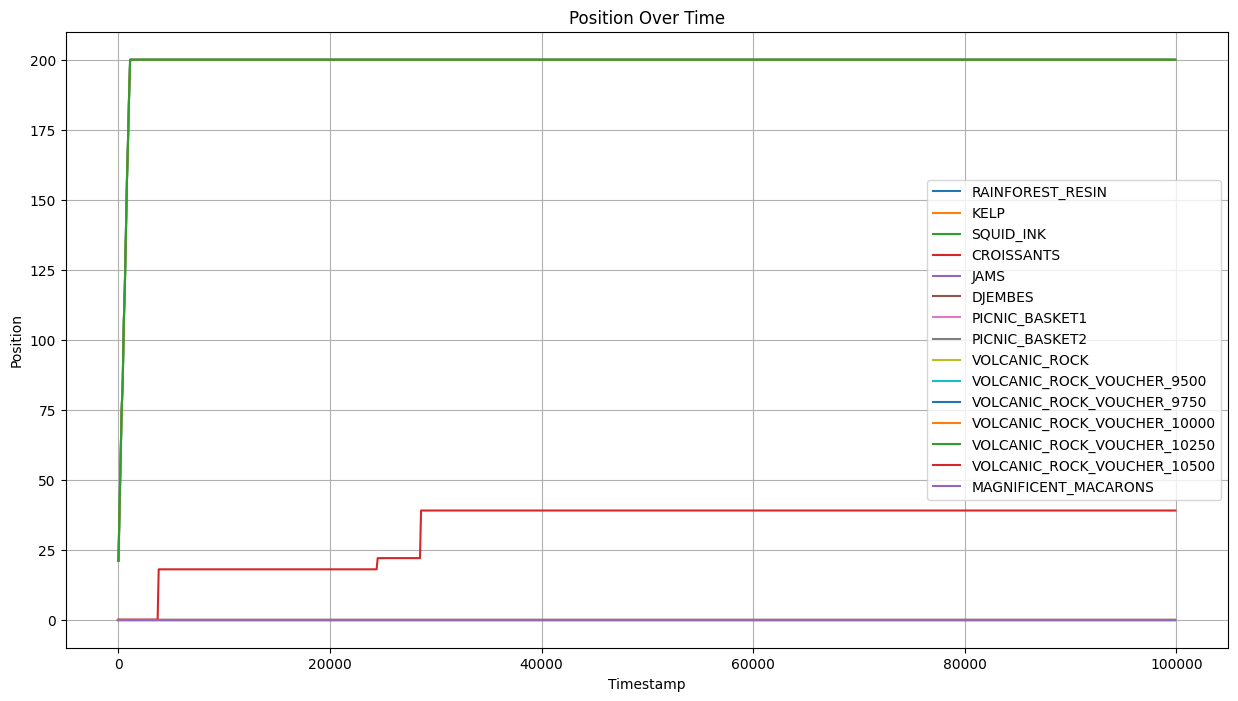

In [258]:
plt.figure(figsize=(15, 8))

for product, dict in product_dict.items():
    # Plot position
    plt.plot(dict['order_book']['timestamp'], dict['order_book']['position'], label=product)
    plt.xlabel('Timestamp')
    plt.ylabel('Position')
    plt.title('Position Over Time')
    plt.legend()
    plt.grid()


# PNL

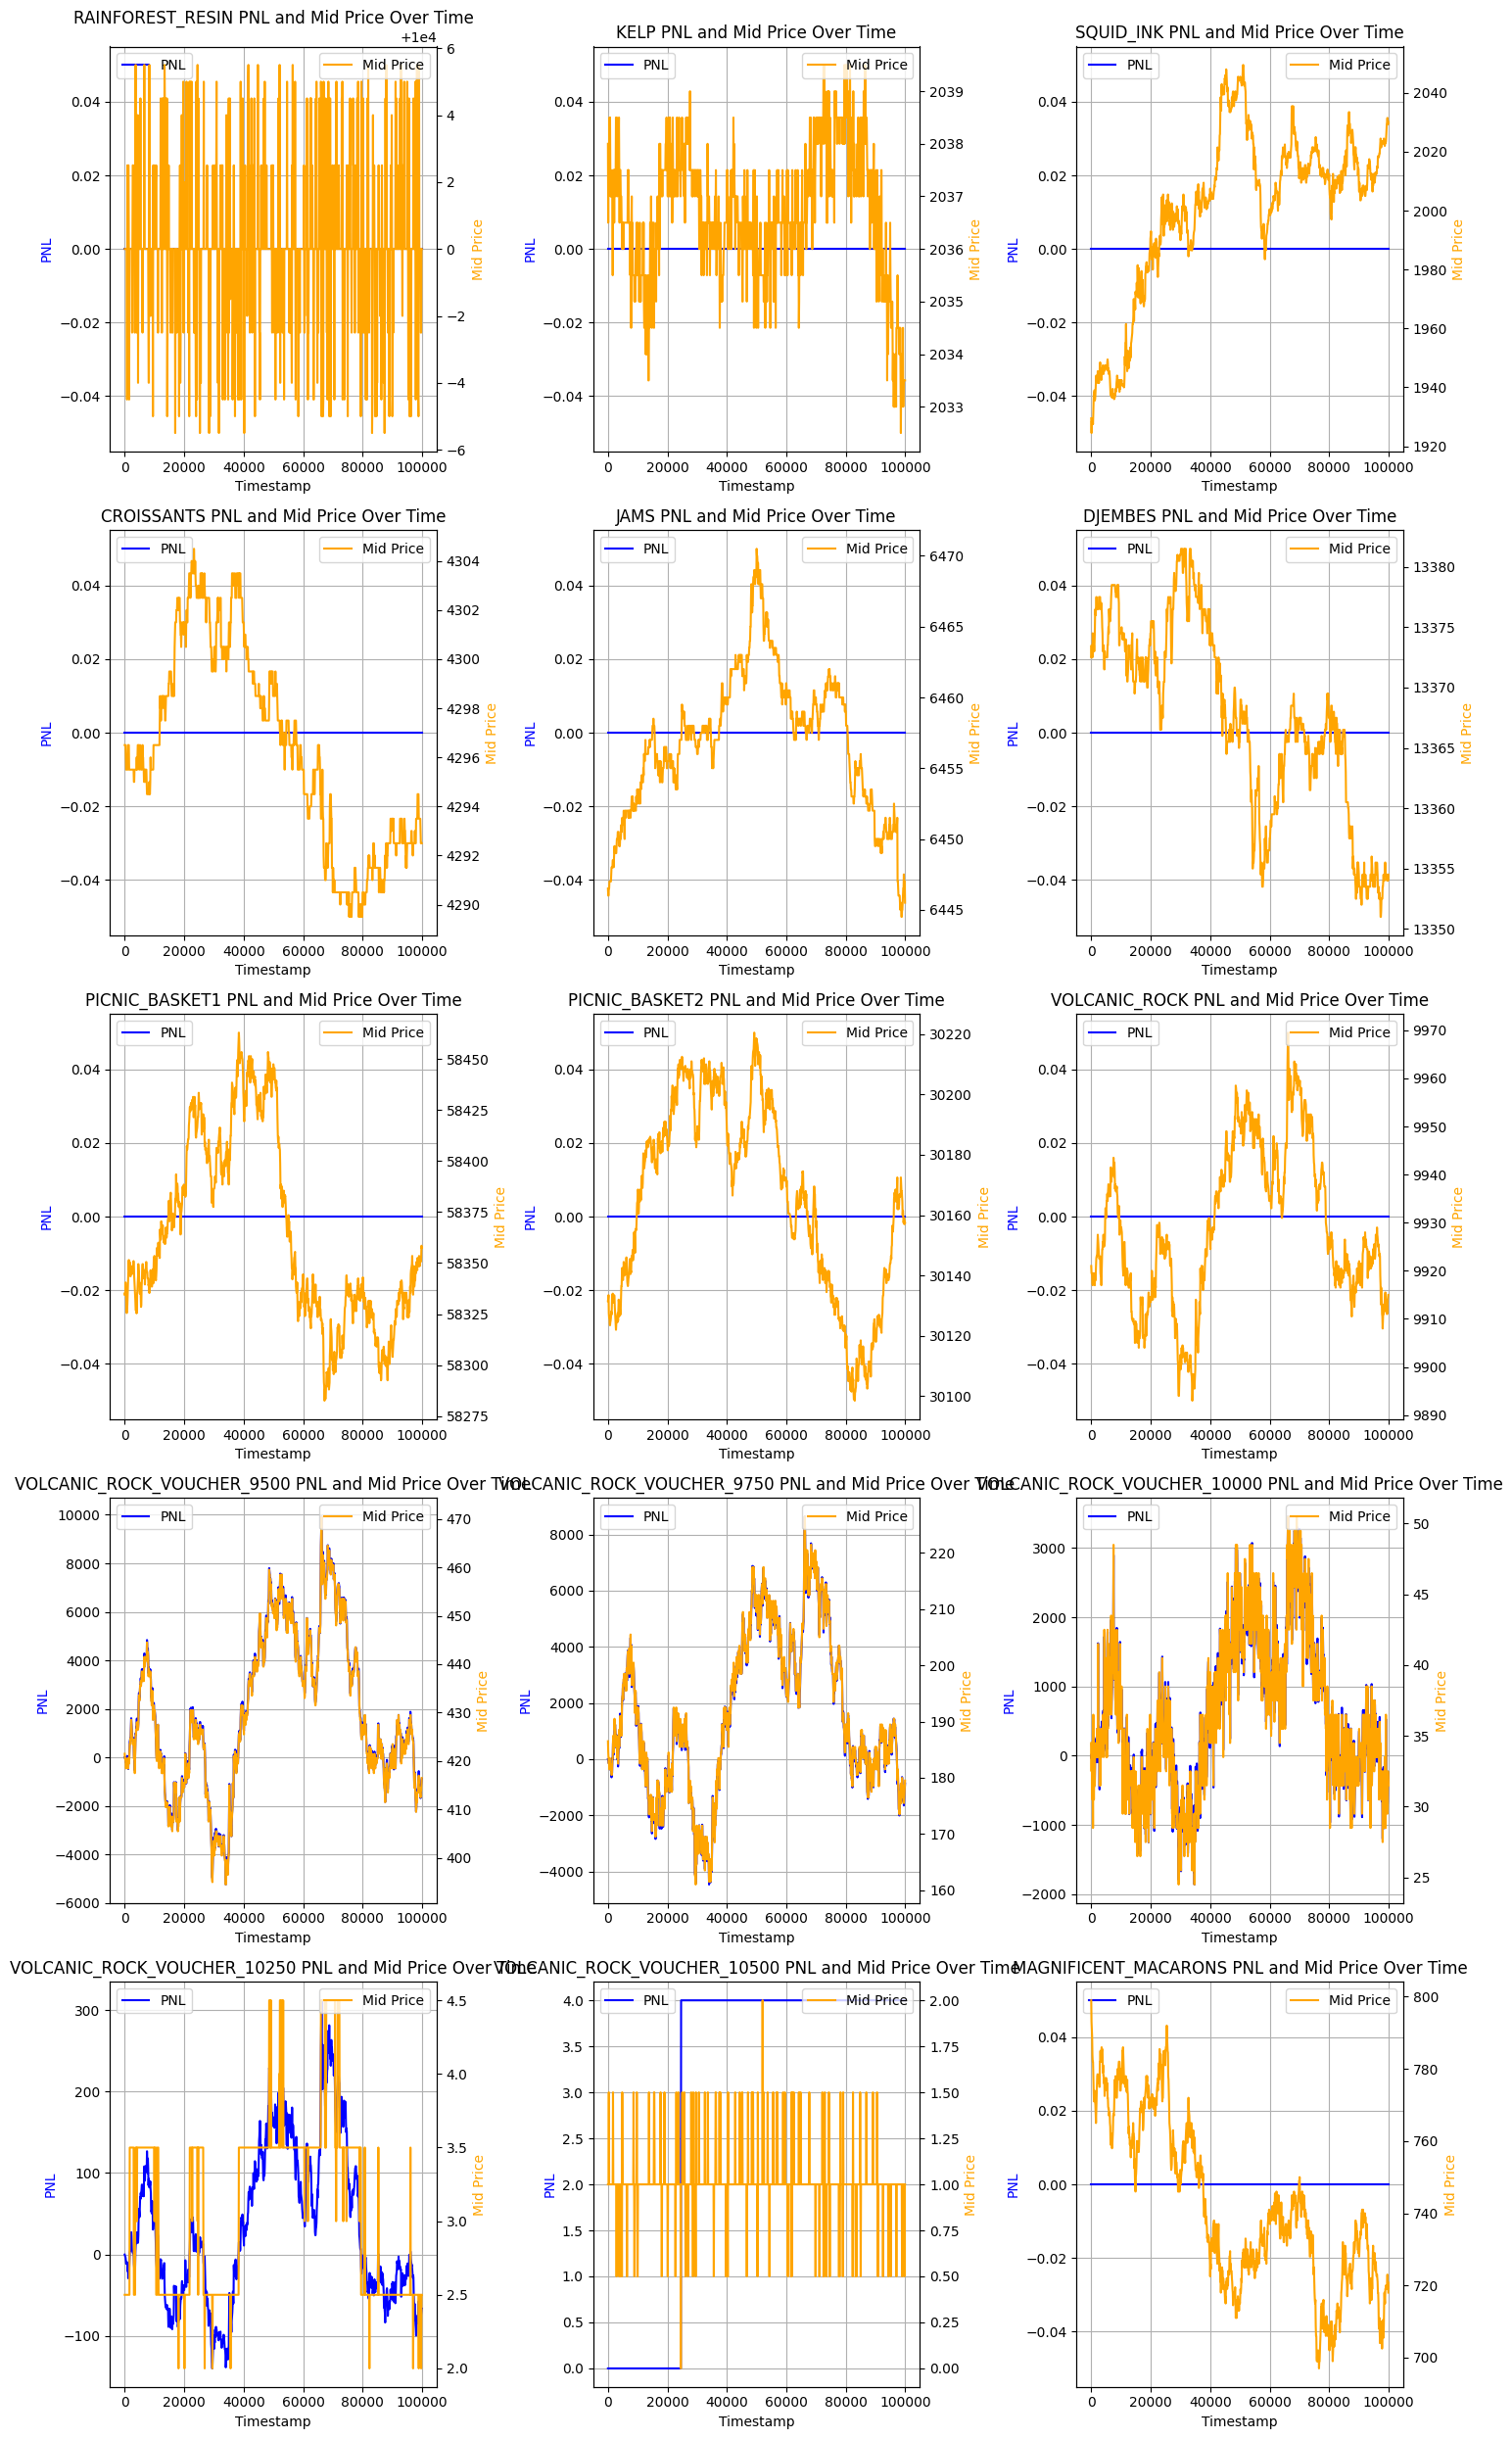

In [247]:
# Determine the number of products and grid size
num_products = len(product_dict)
cols = 3  # Number of columns in the grid
rows = (num_products + cols - 1) // cols  # Calculate rows needed

fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 5))
axes = axes.flatten()  # Flatten the axes array for easy iteration

# Plot each product's PnL and mid price in a subplot
for i, (product, data) in enumerate(product_dict.items()):
    ax = axes[i]
    if 'profit_and_loss' in data['order_book'].columns and 'mid_price' in data['order_book'].columns:
        ax.plot(data['order_book']['timestamp'], data['order_book']['profit_and_loss'], label='PNL', color='blue')
        ax.set_title(f'{product} PNL and Mid Price Over Time')
        ax.set_xlabel('Timestamp')
        ax.set_ylabel('PNL', color='blue')
        ax.grid()
        ax.legend(loc='upper left')

        # Create a secondary y-axis for mid price
        ax2 = ax.twinx()
        ax2.plot(data['order_book']['timestamp'], data['order_book']['mid_price'], label='Mid Price', color='orange')
        ax2.set_ylabel('Mid Price', color='orange')
        ax2.legend(loc='upper right')

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

# VOLCANIC ROCK POSITIONS

In [234]:
def bisection_iv(
        S: float,
        V: float,
        K: int,
        TTT: float,
        low: float = 1e-4,
        high: float = 1.0,
        tol: float = 1e-4,
        max_iter: int = 10
) -> Tuple[float, float]:
    """
    Bisection method to find the implied volatility and delta.
    """
    N = NormalDist()
    for _ in range(max_iter):
        iv = (low + high) / 2
        d1 = (log(S / K) + (0.5 * high**2) * TTT) / (high * sqrt(TTT))
        d2 = d1 - high * sqrt(TTT)
        delta = N.cdf(d1)
        price = S * delta - K * N.cdf(d2)
        if abs(price - V) < tol:
            return iv, delta
        if price > V:
            high = iv
        else:
            low = iv
    return iv, delta

def black_scholes_price(
        S: float,
        K: int,
        TTE: float,
        iv: float,
        r: float = 0.0
) -> float:
    """
    Calculate the Black-Scholes price.
    """
    N = NormalDist()
    d1 = (log(S / K) + (0.5 * iv**2) * TTE) / (iv * sqrt(TTE))
    d2 = d1 - iv * sqrt(TTE)
    call_price = S * N.cdf(d1) - K * exp(-r * TTE) * N.cdf(d2)
    return call_price


def add_volcanic_rock_metrics(df: pd.DataFrame) -> pd.DataFrame:
    """
    For each row in df (with columns 'timestamp' and 'mid_price'), compute:
      - iv_{strike}, delta_{strike}
      - moneyness_{strike}
      - iv_fit_{strike}, misvol_{strike}, fair_{strike}
    for strikes = [9500, 9750, 10000, 10250, 10500], and append all as new cols.
    """
    strikes = [9500, 9750, 10000, 10250, 10500]
    
    def compute_row(row):
        S = row['mid_price']
        TTE = (3e6 - row['timestamp']) / (1e6 * 365)
        out = {}
        # 1) raw IV + delta + moneyness
        for K in strikes:
            # assume you've pre–merged in the voucher mid‐prices as e.g. mid_price_9500, etc.
            V = row[f'mid_price_{K}']
            iv, delta = bisection_iv(S, V, K, TTE)
            m = np.log(K / S) / np.sqrt(TTE)
            out[f'iv_{K}'] = iv
            out[f'delta_{K}'] = delta
            out[f'moneyness_{K}'] = m
        
        # 2) fit a quadratic IV curve
        m_vals = [out[f'moneyness_{K}'] for K in strikes]
        iv_vals = [out[f'iv_{K}']       for K in strikes]
        a, b, c = np.polyfit(m_vals, iv_vals, 2)
        
        # 3) iv_fit, misvol, fair
        for K in strikes:
            m = out[f'moneyness_{K}']
            iv_fit = a*m*m + b*m + c
            fair = black_scholes_price(S, K, TTE, out[f'iv_{K}'])
            out[f'iv_fit_{K}']  = iv_fit
            out[f'misvol_{K}']  = out[f'iv_{K}'] - iv_fit
            out[f'fair_{K}']    = fair
        
        return pd.Series(out)
    
    # apply row‐wise and concat
    metrics = df.apply(compute_row, axis=1)
    return pd.concat([df, metrics], axis=1)

volcanic_rock_df = product_dict["VOLCANIC_ROCK"]["order_book"].copy()

for K in [9500, 9750, 10000, 10250, 10500]:
    voucher_df = product_dict[f"VOLCANIC_ROCK_VOUCHER_{K}"]["order_book"]
    volcanic_rock_df[f'mid_price_{K}'] = voucher_df['mid_price'].values

volcanic_rock_df = volcanic_rock_df.copy()

volcanic_rock_df = add_volcanic_rock_metrics(volcanic_rock_df)

# for each strike print a summary of fair price and mid price
for K in [9500, 9750, 10000, 10250, 10500]:
    print(f"Strike {K}:")
    print(volcanic_rock_df[[f'mid_price_{K}', f'fair_{K}']].describe())

Strike 9500:
       mid_price_9500    fair_9500
count      1000.00000  1000.000000
mean        429.98500   428.996162
std          16.01472    16.177983
min         394.50000   393.003860
25%         418.50000   417.501517
50%         427.50000   426.001178
75%         441.50000   441.000605
max         470.50000   469.500166
Strike 9750:
       mid_price_9750    fair_9750
count     1000.000000  1000.000000
mean       191.541500   181.481862
std         14.073738    15.319935
min        161.000000   147.987477
25%        181.500000   170.555178
50%        188.500000   178.610878
75%        202.500000   192.814995
max        226.500000   220.429407
Strike 10000:
       mid_price_10000   fair_10000
count      1000.000000  1000.000000
mean         36.485500    17.979691
std           5.445291     4.315275
min          24.500000     9.970320
25%          32.500000    14.776134
50%          35.500000    16.879418
75%          40.500000    21.100439
max          50.500000    30.732244
Strike

Strike 9500:
  Average difference: 0.9888376945684413
  Standard deviation: 0.39240596879335243
  1st percentile: 0.0 (Adjusted: 0.9888376945684413)
  99th percentile: 1.9983778160095427 (Adjusted: 2.987215510577984)
  Difference between average and 1st percentile: 0.9888376945684413
  Difference between average and 99th percentile: -1.0095401214411015


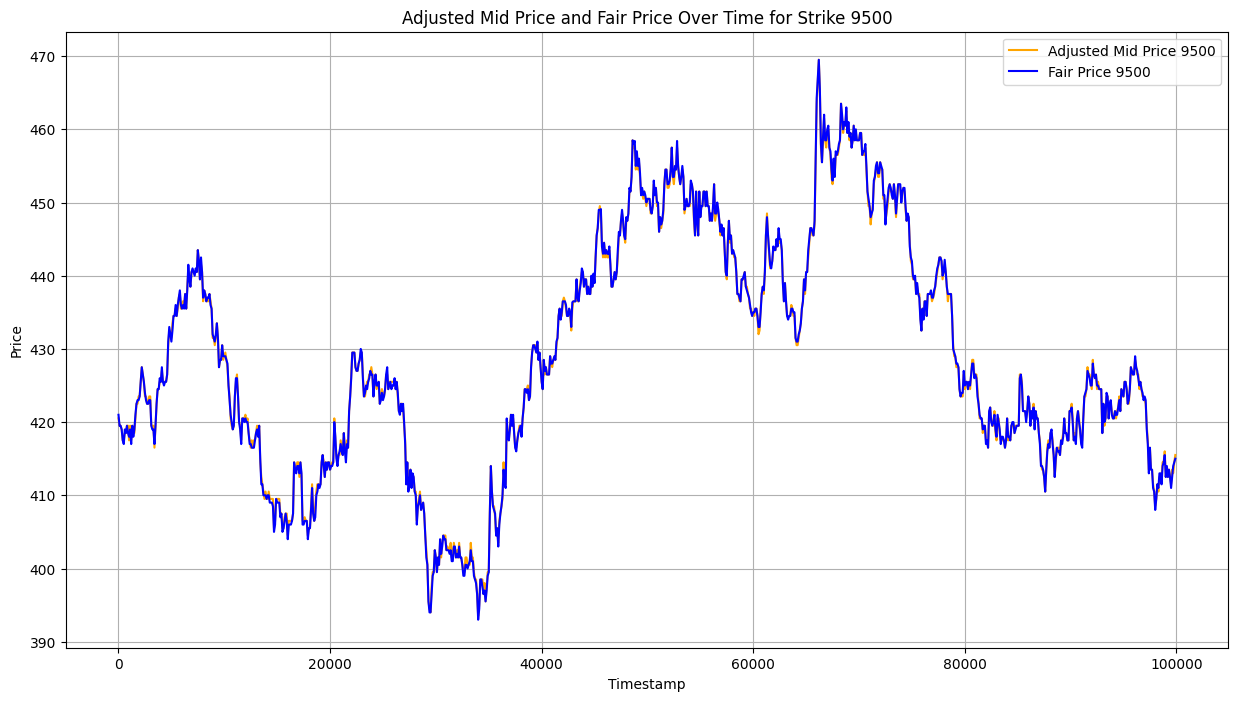

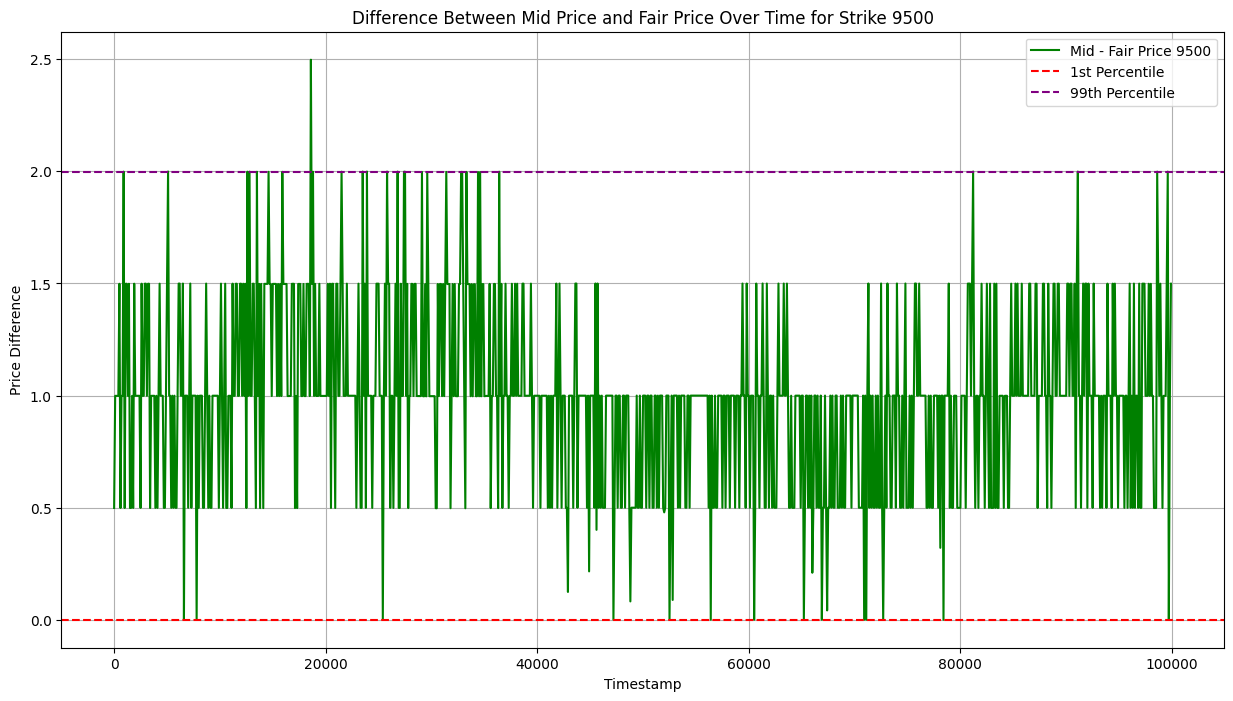

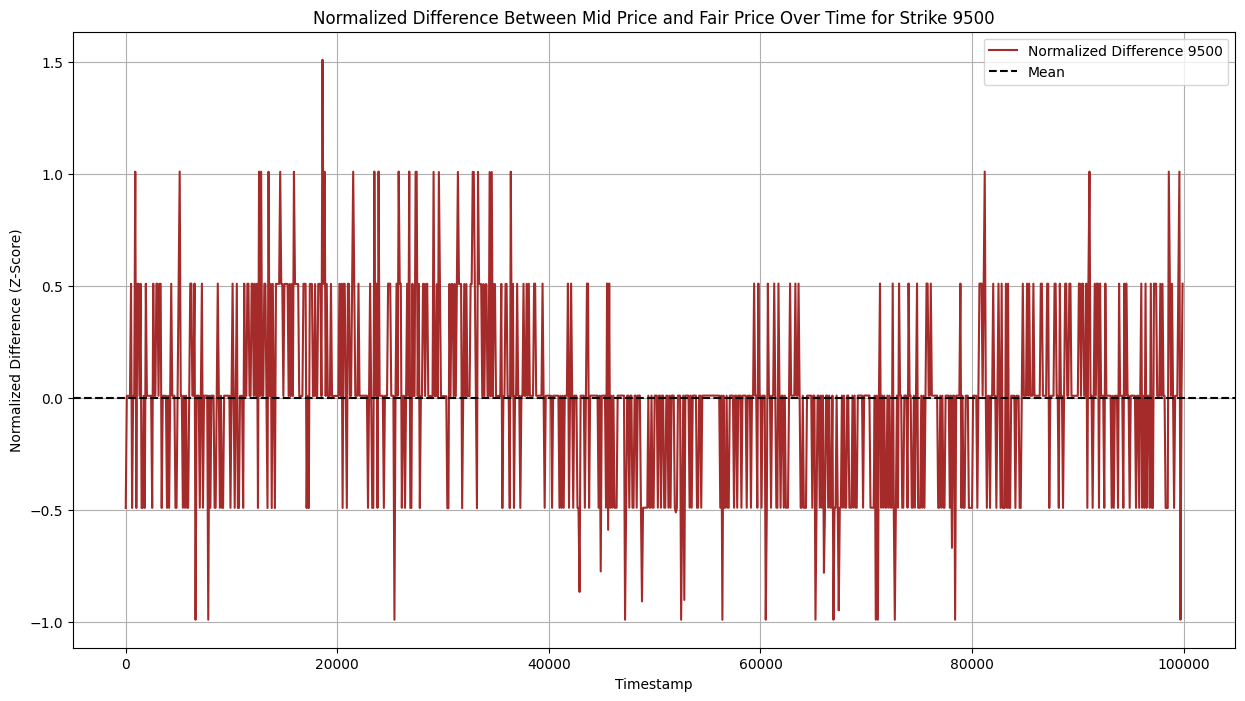

Strike 9750:
  Average difference: 10.059637955587375
  Standard deviation: 1.7743177656074731
  1st percentile: 6.307294419176888 (Adjusted: 16.36693237476426)
  99th percentile: 14.388827428345211 (Adjusted: 24.448465383932586)
  Difference between average and 1st percentile: 3.7523435364104873
  Difference between average and 99th percentile: -4.329189472757836


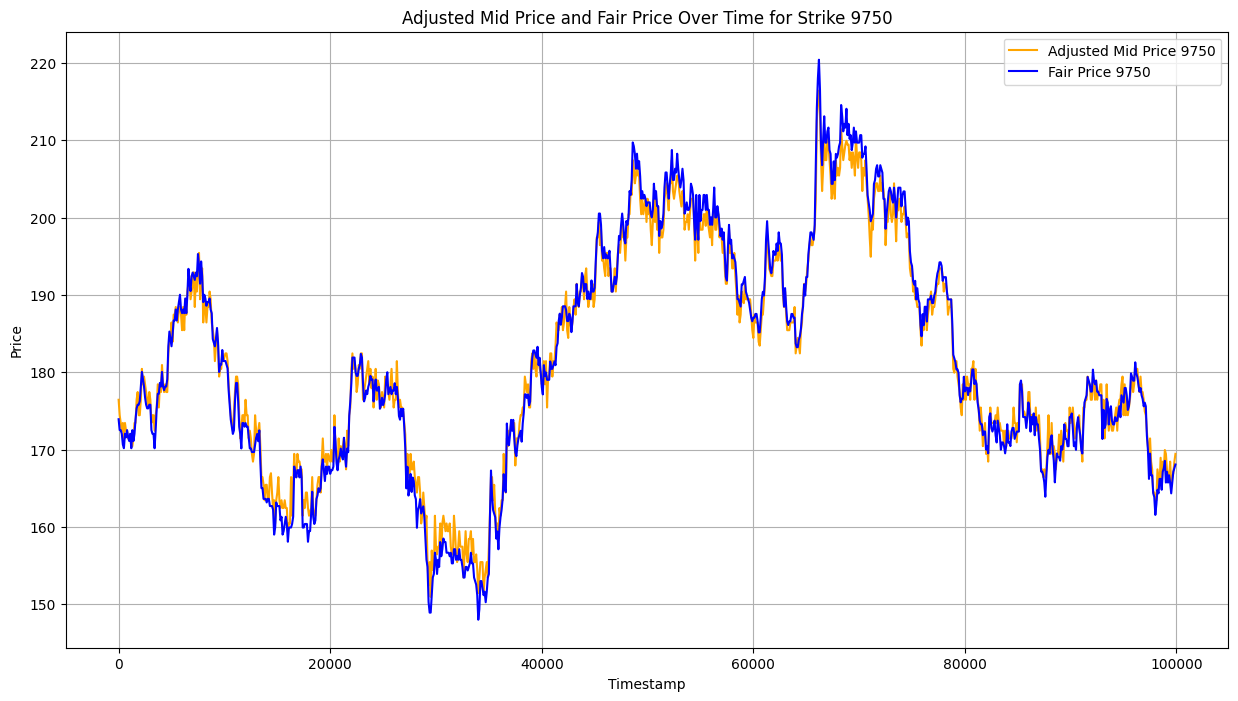

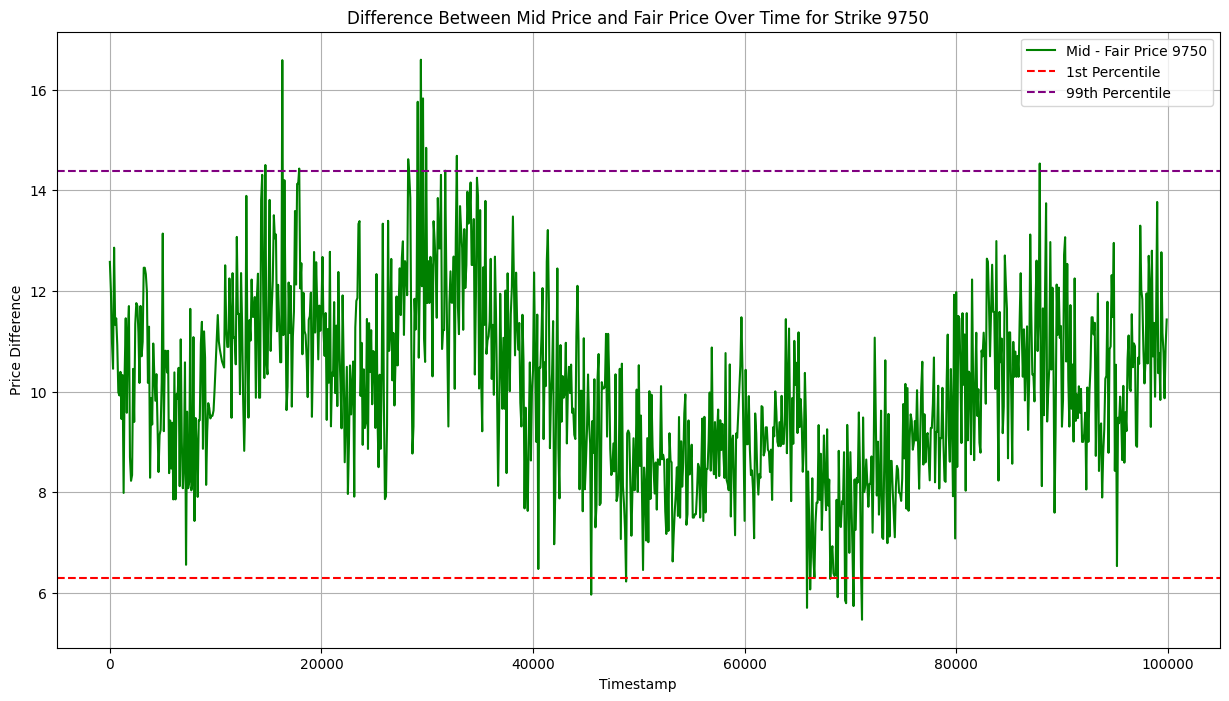

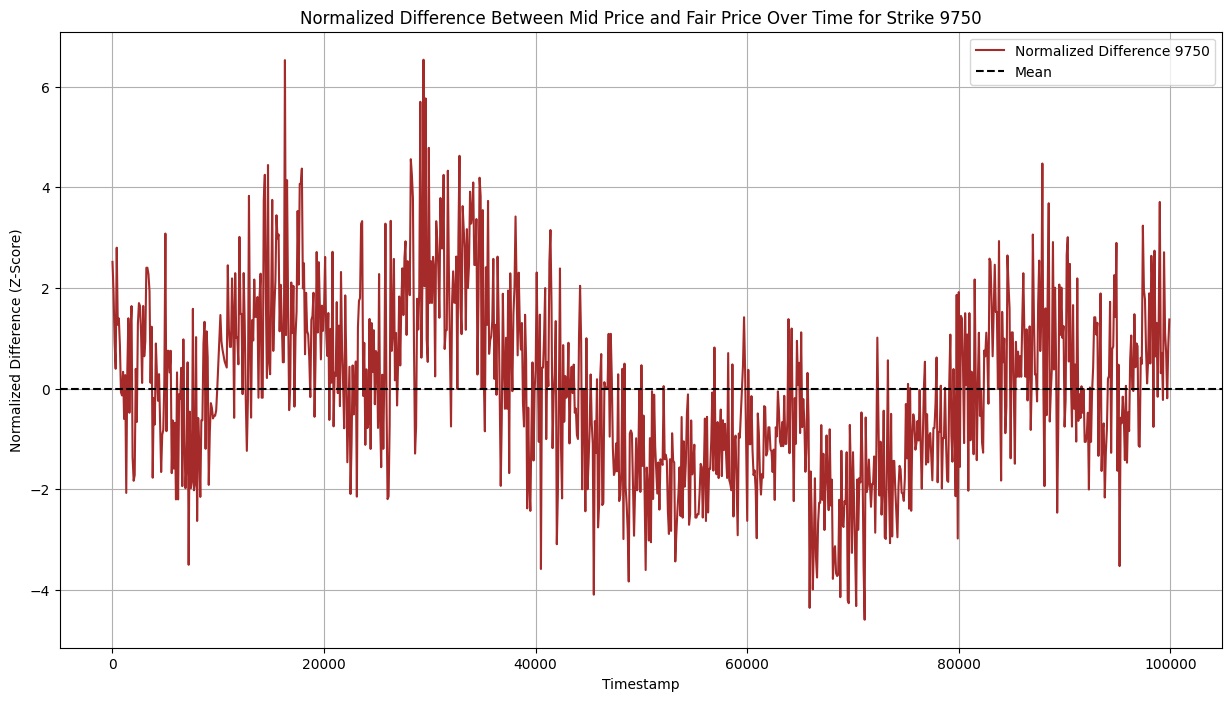

Strike 10000:
  Average difference: 18.50580907925521
  Standard deviation: 2.107505942696751
  1st percentile: 13.860125497428417 (Adjusted: 32.36593457668363)
  99th percentile: 23.545747728200126 (Adjusted: 42.05155680745534)
  Difference between average and 1st percentile: 4.645683581826795
  Difference between average and 99th percentile: -5.039938648944915


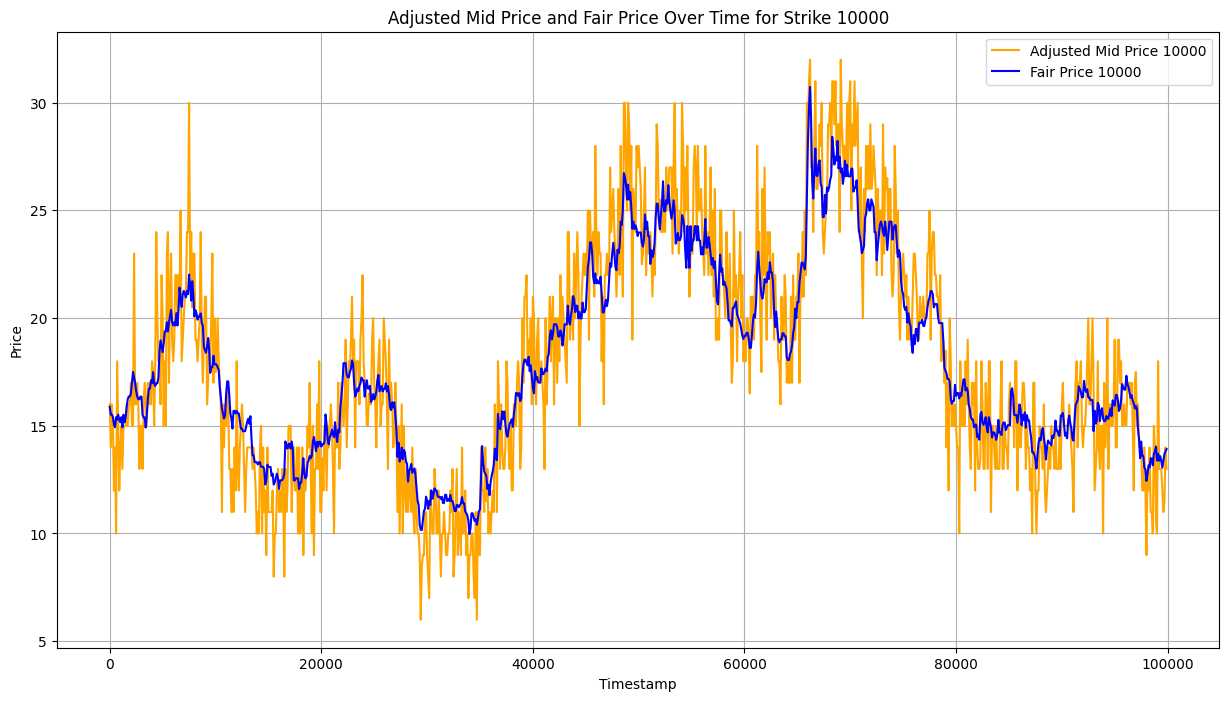

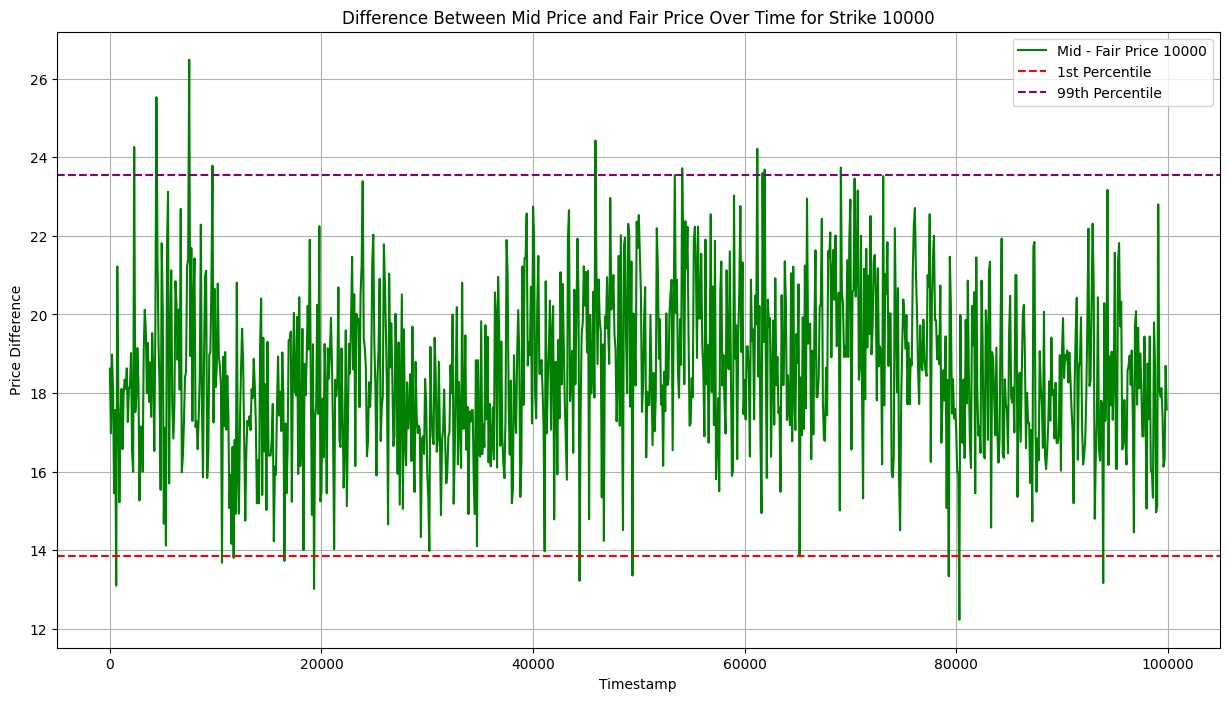

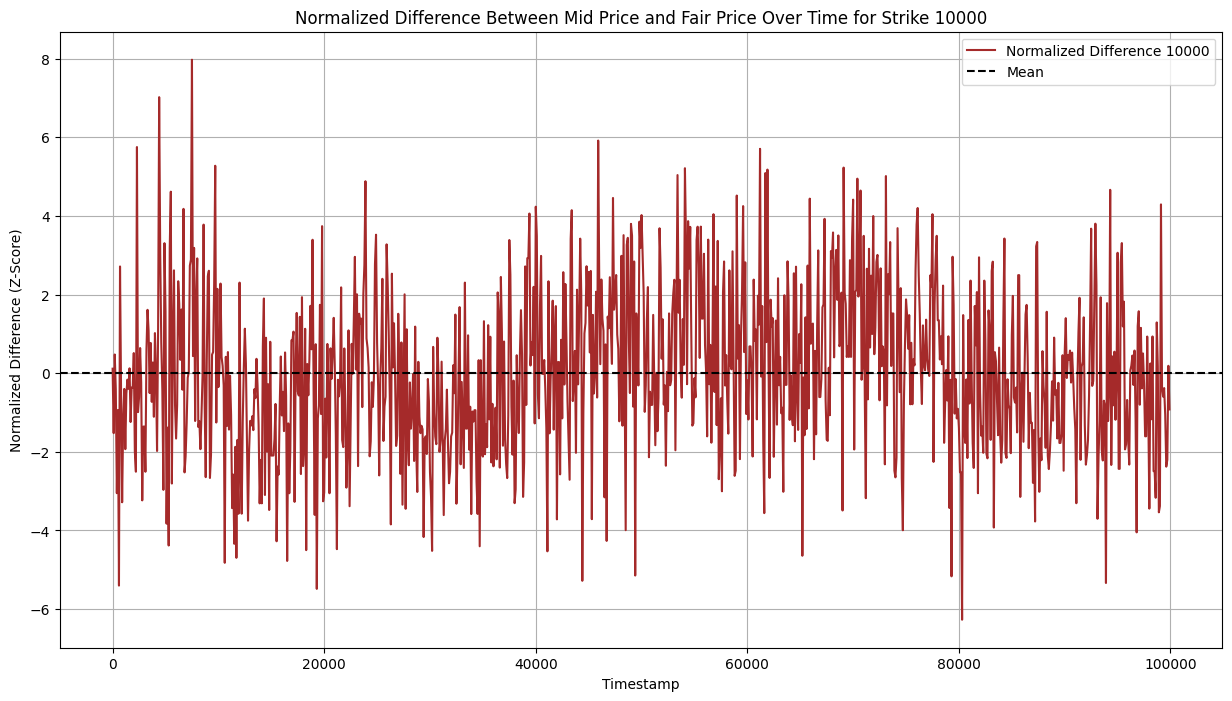

Strike 10250:
  Average difference: 3.0228510570463096
  Standard deviation: 0.5766935451980523
  1st percentile: 2.4359903662289497 (Adjusted: 5.45884142327526)
  99th percentile: 4.345709167104549 (Adjusted: 7.368560224150858)
  Difference between average and 1st percentile: 0.5868606908173599
  Difference between average and 99th percentile: -1.3228581100582395


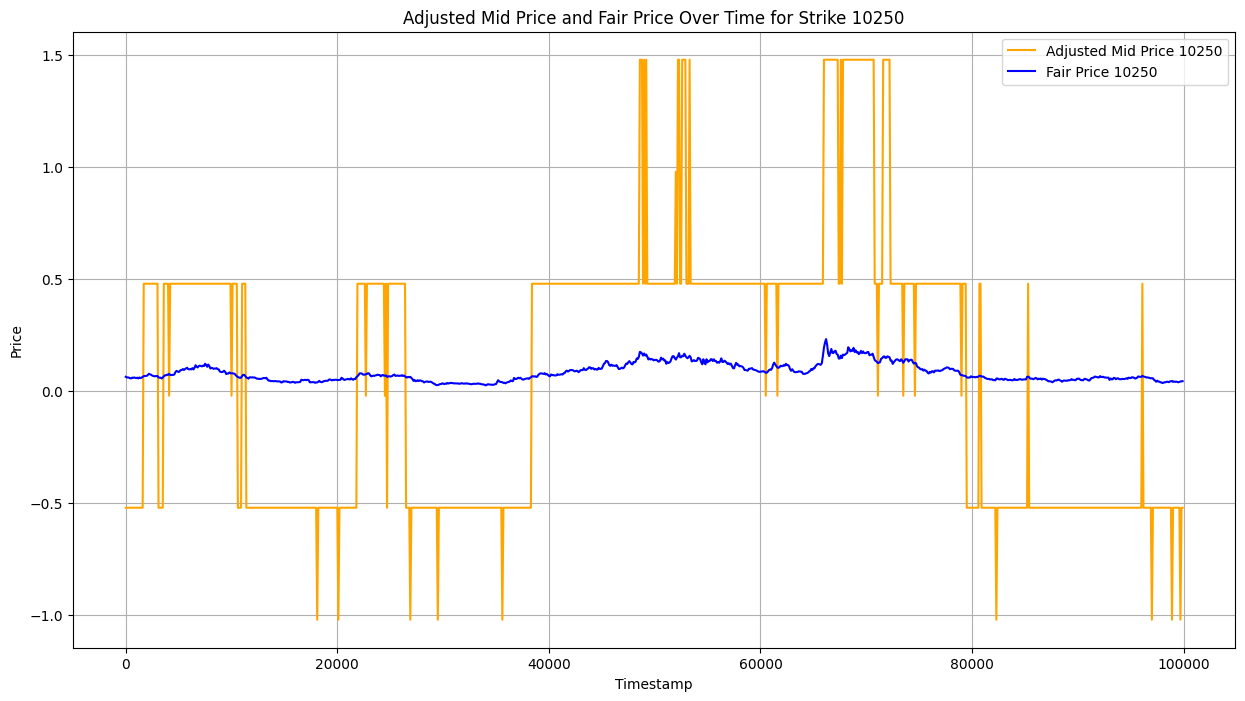

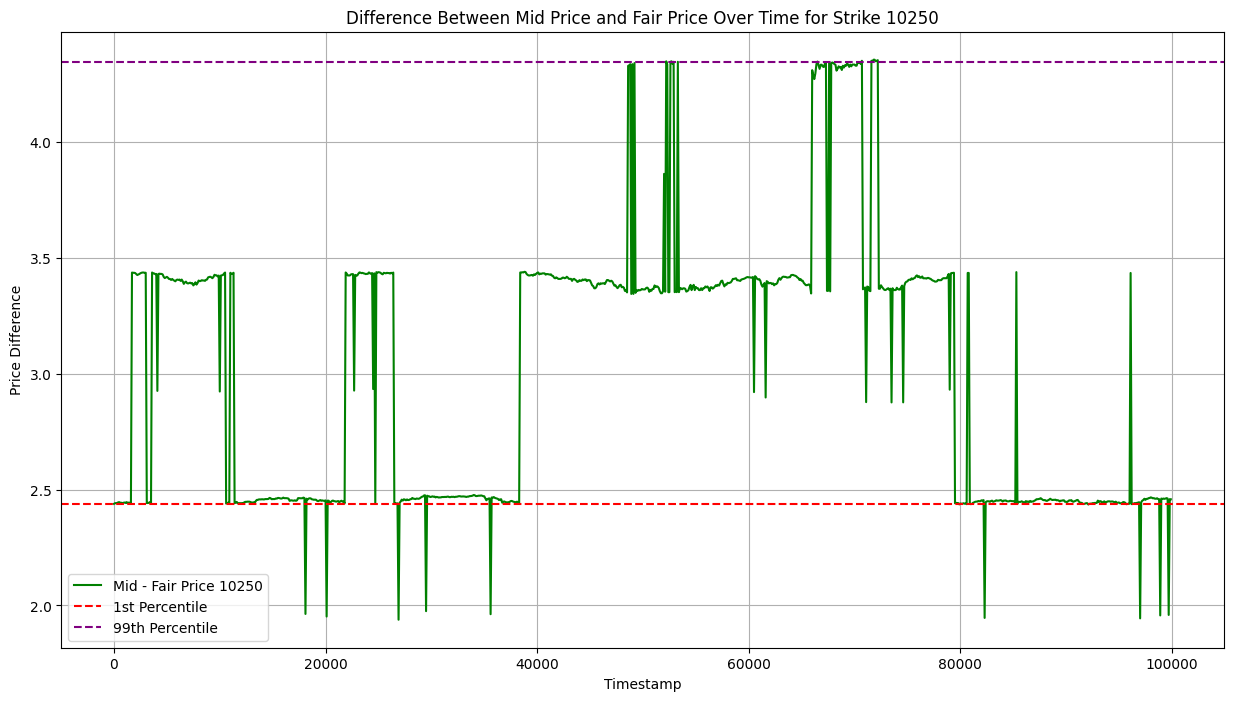

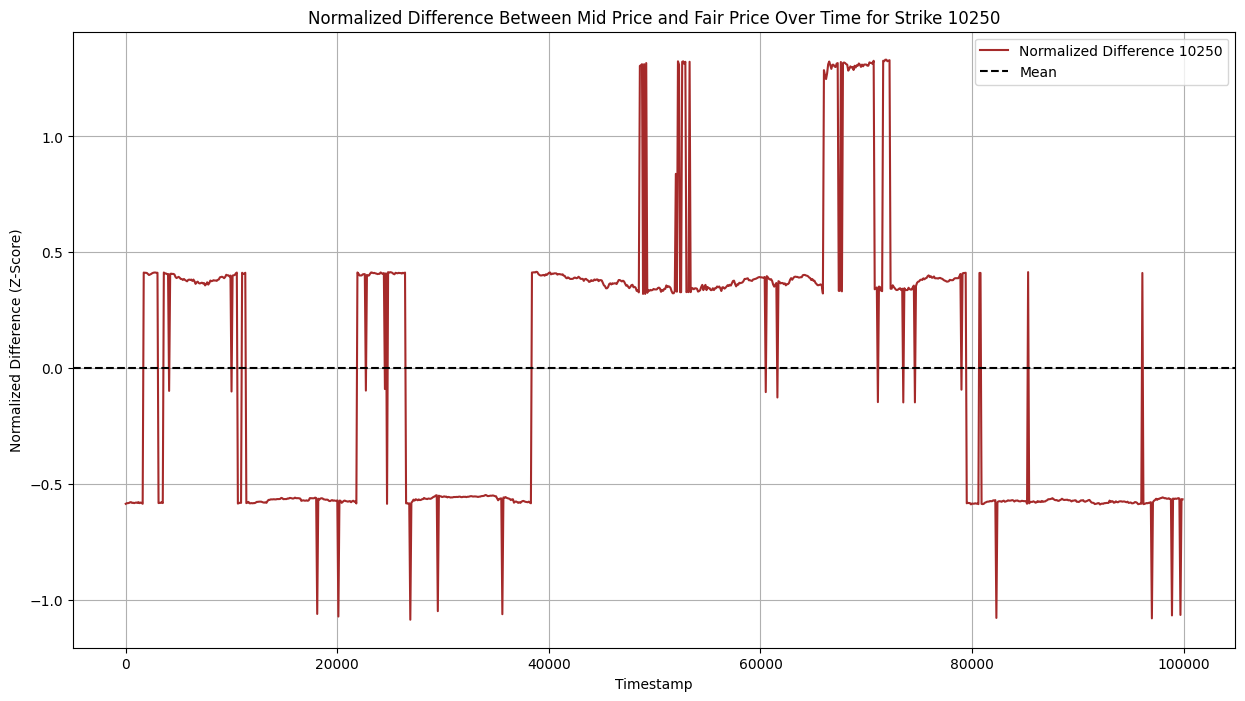

Strike 10500:
  Average difference: 0.5451881070496024
  Standard deviation: 0.1737013285265313
  1st percentile: 0.08825797600329793 (Adjusted: 0.6334460830529003)
  99th percentile: 1.1388348404748612 (Adjusted: 1.6840229475244635)
  Difference between average and 1st percentile: 0.4569301310463045
  Difference between average and 99th percentile: -0.5936467334252588


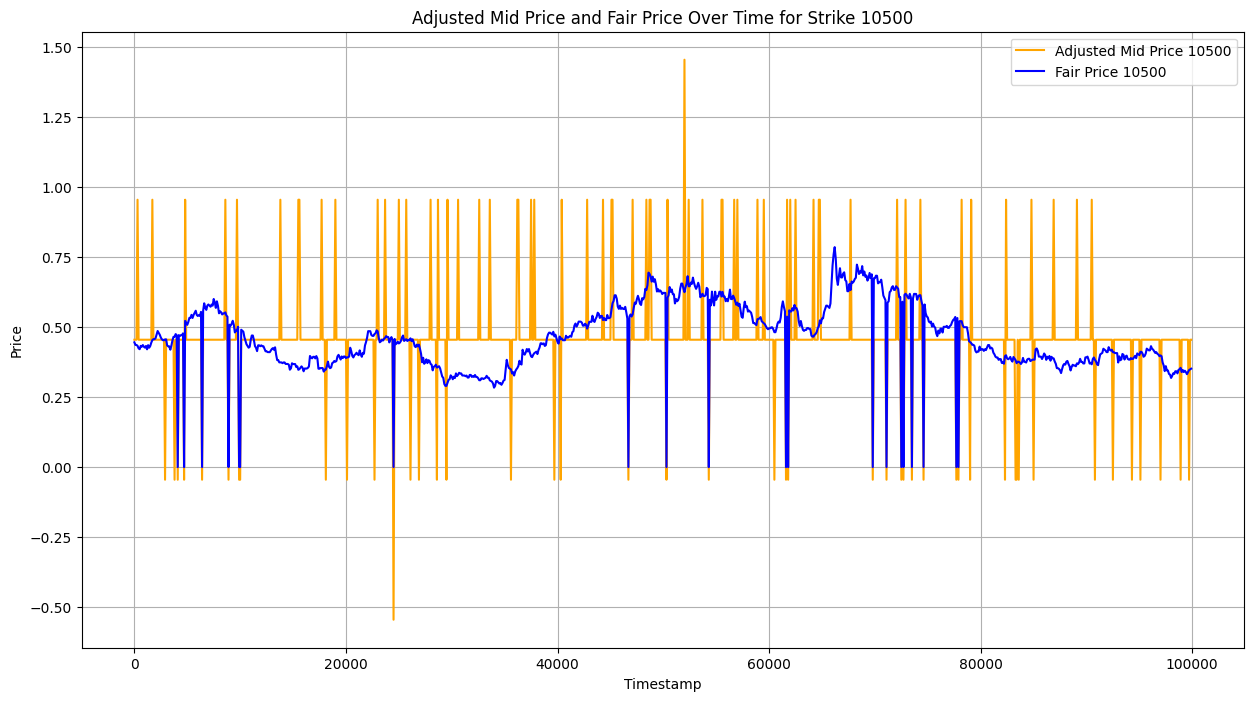

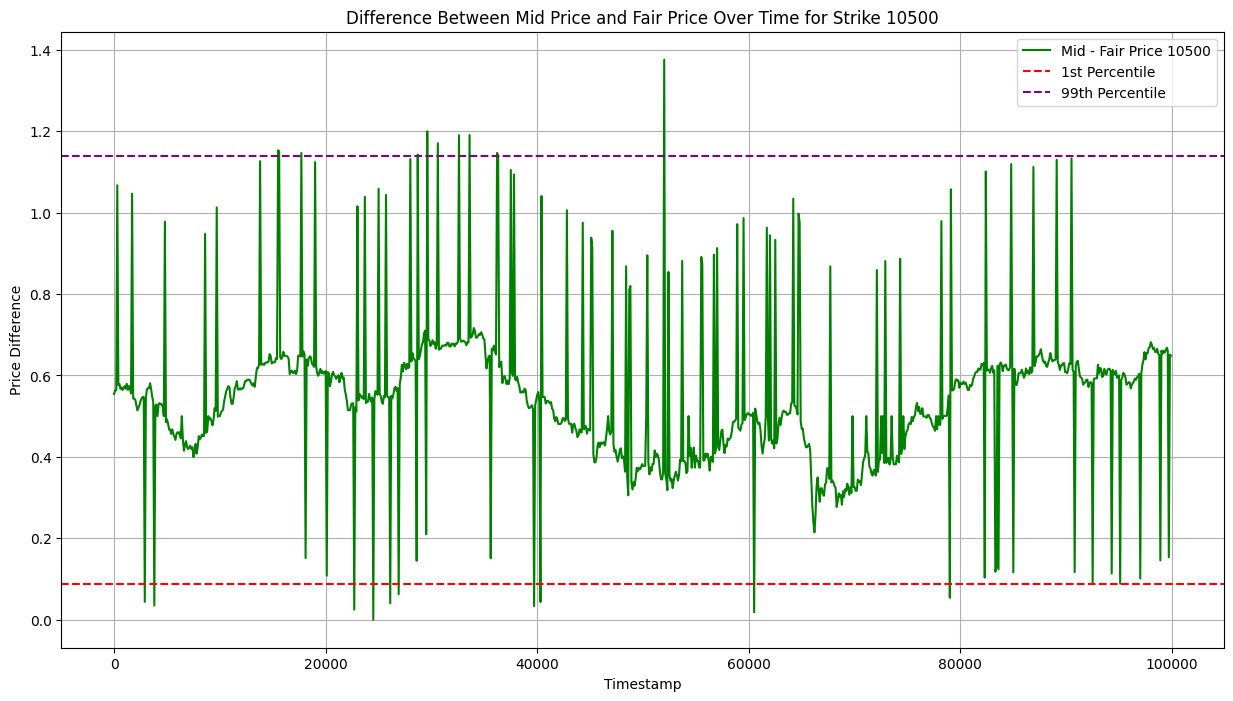

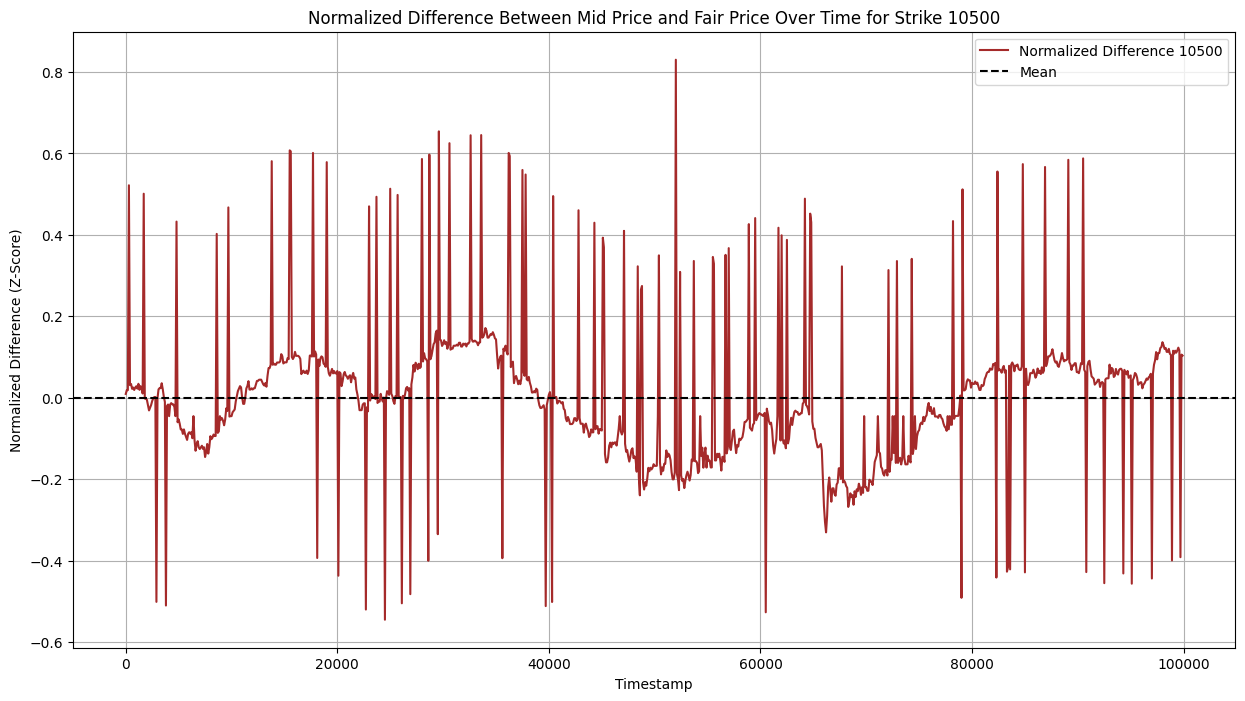

In [262]:
for K in [9500, 9750, 10000, 10250, 10500]:
    price_diff = volcanic_rock_df[f'mid_price_{K}'] - volcanic_rock_df[f'fair_{K}']
    avg_diff = price_diff.mean()
    std_diff = price_diff.std()
    percentile_1 = price_diff.quantile(0.01)
    percentile_99 = price_diff.quantile(0.99)
    
    # Normalize the difference (z-score)
    normalized_diff = (price_diff - avg_diff)
    
    print(f"Strike {K}:")
    print(f"  Average difference: {avg_diff}")
    print(f"  Standard deviation: {std_diff}")
    print(f"  1st percentile: {percentile_1} (Adjusted: {percentile_1 + avg_diff})")
    print(f"  99th percentile: {percentile_99} (Adjusted: {percentile_99 + avg_diff})")
    print(f"  Difference between average and 1st percentile: {avg_diff - percentile_1}")
    print(f"  Difference between average and 99th percentile: {avg_diff - percentile_99}")
    
    # Plot mid price (adjusted) and fair value
    plt.figure(figsize=(15, 8))
    plt.plot(volcanic_rock_df['timestamp'], volcanic_rock_df[f'mid_price_{K}'] - avg_diff, label=f'Adjusted Mid Price {K}', color='orange')
    plt.plot(volcanic_rock_df['timestamp'], volcanic_rock_df[f'fair_{K}'], label=f'Fair Price {K}', color='blue')
    plt.xlabel('Timestamp')
    plt.ylabel('Price')
    plt.title(f'Adjusted Mid Price and Fair Price Over Time for Strike {K}')
    plt.legend()
    plt.grid()
    plt.show()
    
    # Plot the difference
    plt.figure(figsize=(15, 8))
    plt.plot(volcanic_rock_df['timestamp'], price_diff, label=f'Mid - Fair Price {K}', color='green')
    plt.axhline(percentile_1, color='red', linestyle='--', label='1st Percentile')
    plt.axhline(percentile_99, color='purple', linestyle='--', label='99th Percentile')
    plt.xlabel('Timestamp')
    plt.ylabel('Price Difference')
    plt.title(f'Difference Between Mid Price and Fair Price Over Time for Strike {K}')
    plt.legend()
    plt.grid()
    plt.show()
    
    # Plot the normalized difference
    plt.figure(figsize=(15, 8))
    plt.plot(volcanic_rock_df['timestamp'], normalized_diff, label=f'Normalized Difference {K}', color='brown')
    plt.axhline(0, color='black', linestyle='--', label='Mean')
    plt.xlabel('Timestamp')
    plt.ylabel('Normalized Difference (Z-Score)')
    plt.title(f'Normalized Difference Between Mid Price and Fair Price Over Time for Strike {K}')
    plt.legend()
    plt.grid()
    plt.show()